Kagge Compwtition, Titanic Machine Learning

Score~80% (top 12%)

In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = [train, test]

# --- FEATURE ENGINEERING ---
for df in full_data:
    # Title extraction
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)  # The r'' tells Python to interpret backslashes literally (as required in regular expressions), so \. means "dot" in regex.
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 
                                       'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace('Master', 'Master')
    # Sex
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    # Age and Fare
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    # FamilySize
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# One-hot for Title (only most common + 'Rare')
for t in ['Mr', 'Miss', 'Mrs', 'Master', 'Rare']:
    for df in full_data:
        df[f'Title_{t}'] = (df['Title'] == t).astype(int)
        
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Title']
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
            'FamilySize', 'IsAlone', 'Title_Mr', 'Title_Miss', 'Title_Mrs', 'Title_Master', 'Title_Rare']

X = train[features]
y = train['Survived']
X_test = test[features]

# --- MODEL ---
model = RandomForestClassifier(
    n_estimators=150, max_depth=5, min_samples_split=6, min_samples_leaf=2, random_state=42
)

# Robust cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("CV accuracy:", cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean())

model.fit(X, y)
y_pred = model.predict(X_test)

# Submission
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred})
output.to_csv('submission_new.csv', index=False)


CV accuracy: 0.8316489862532169


In [7]:
import pandas as pd
import numpy as np

print("Submission shape:", submission.shape)
# Or, if using 'output'
print("Output shape:", output.shape)

Submission shape: (0, 0)
Output shape: (418, 2)


In [9]:
print(submission.columns)
# Or, for output:
print(output.columns)

RangeIndex(start=0, stop=0, step=1)
Index(['PassengerId', 'Survived'], dtype='object')


In [18]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier  # Import XGBClassifier from xgboost
import pandas as pd  # Import pandas for DataFrame operations

voting = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=3, eval_metric='logloss', random_state=42))
], voting='soft')

voting.fit(X, y)
y_pred = voting.predict(X_test)

submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred})
submission.to_csv('submission_new2.csv', index=False)

In [24]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# Define your base models
rf = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=6, min_samples_leaf=2, random_state=42)
gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42)
xgb = XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=3,
    eval_metric='logloss',
    random_state=42
)

# Voting ensemble
voting = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('xgb', xgb)
    ],
    voting='soft'  # Try 'hard' if you want to experiment
)

# Fit on the full training set
voting.fit(X, y)

# Predict for the test set
y_pred = voting.predict(X_test)

# Save submission
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred.astype(int)})
submission.to_csv('submission.csv', index=False)

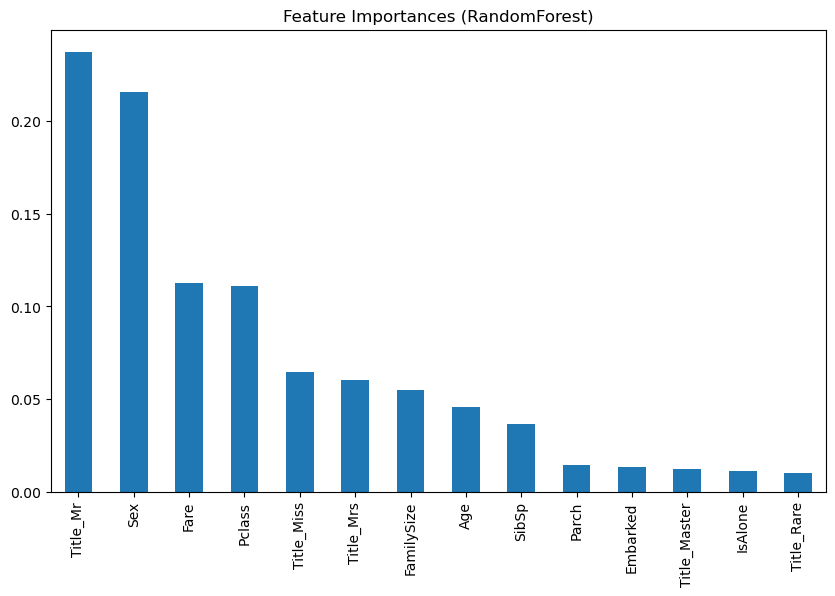

In [22]:
import matplotlib.pyplot as plt

# Fit a RandomForest to get feature importances
rf.fit(X, y)
importances = rf.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title('Feature Importances (RandomForest)')
plt.show()

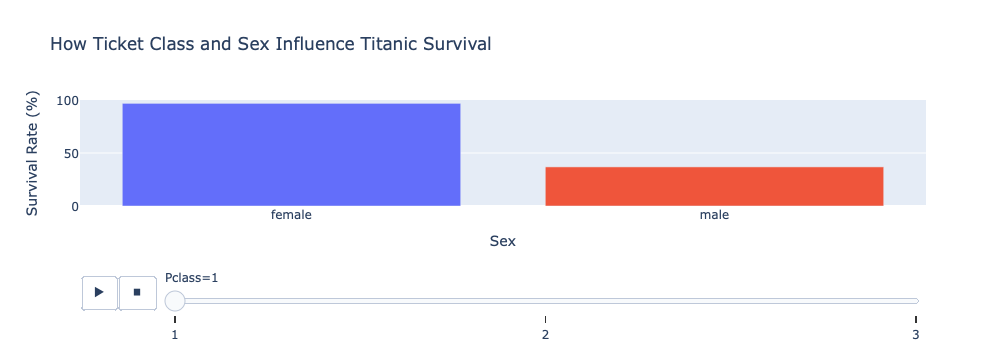

In [30]:
import plotly.express as px
import pandas as pd

# Assuming you have your Titanic data loaded as train DataFrame
# If 'Sex' is encoded, decode it for labels:
if train['Sex'].dtype != 'O':
    train['Sex_label'] = train['Sex'].map({0: 'male', 1: 'female'})
else:
    train['Sex_label'] = train['Sex']

# Group by class and sex to get mean survival
grouped = train.groupby(['Pclass', 'Sex_label'])['Survived'].mean().reset_index()
grouped['Survival Rate'] = grouped['Survived'] * 100

fig = px.bar(
    grouped,
    x="Sex_label",
    y="Survival Rate",
    color="Sex_label",
    animation_frame="Pclass",
    range_y=[0, 100],
    labels={'Sex_label': 'Sex', 'Survival Rate': 'Survival Rate (%)'},
    title="How Ticket Class and Sex Influence Titanic Survival"
)
fig.update_layout(xaxis_title="Sex", yaxis_title="Survival Rate (%)", showlegend=False)
fig.show()

This animation shows that survival rates were strongly influenced by both ticket class and sex. Pclass=1 (first class) represents the wealthiest passengers, Pclass=2 is middle class, and Pclass=3 is third class. Females in first class had the highest survival probability, while males in third class had the lowest, revealing a strong interaction between class, gender, and survival outcomes.

Total surviving women: 233


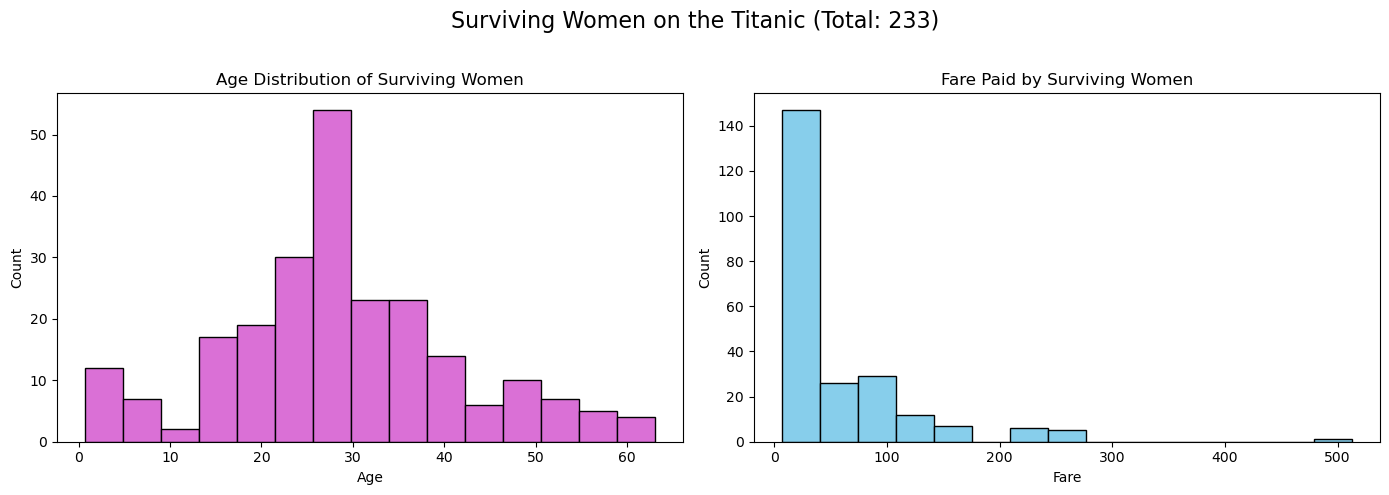

In [37]:
# Filter for surviving women
surviving_women = train[(train['Sex'] == 1) | (train['Sex'] == 'female')]
surviving_women = surviving_women[surviving_women['Survived'] == 1]

total_count = surviving_women.shape[0]
print(f"Total surviving women: {total_count}")

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Age Histogram
axs[0].hist(surviving_women['Age'].dropna(), bins=15, color='orchid', edgecolor='k')
axs[0].set_title('Age Distribution of Surviving Women')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Count')

# Fare Histogram
axs[1].hist(surviving_women['Fare'].dropna(), bins=15, color='skyblue', edgecolor='k')
axs[1].set_title('Fare Paid by Surviving Women')
axs[1].set_xlabel('Fare')
axs[1].set_ylabel('Count')

plt.suptitle(f"Surviving Women on the Titanic (Total: {total_count})", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



Let's normalize in % values, to get a more appeling understanding of the survival rate of woman

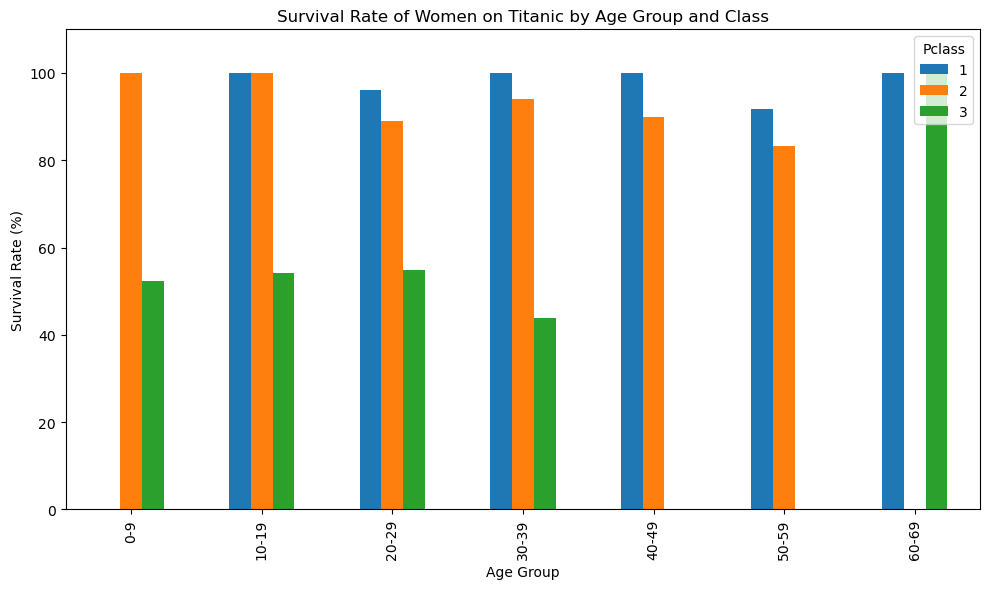

In [45]:
# Filter only women
women = train[(train['Sex'] == 1) | (train['Sex'] == 'female')].copy()

# Fix: Ensure the number of labels matches the number of bins
# The range(0, 90, 10) creates bin edges at [0, 10, 20, 30, 40, 50, 60, 70, 80]
# This creates 8 bins, so we need 8 labels
women['AgeGroup'] = pd.cut(women['Age'], 
                          bins=range(0, 90, 10), 
                          right=False, 
                          labels=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79'])

# Group by AgeGroup and Pclass, then calculate survival rate
# Add observed=True to address the FutureWarning
summary = women.groupby(['AgeGroup', 'Pclass'], observed=True).agg(
    total=('Survived', 'count'),
    survived=('Survived', 'sum')
).reset_index()
summary['SurvivalRate'] = (summary['survived'] / summary['total']) * 100

# Pivot for easier plotting
pivot = summary.pivot(index='AgeGroup', columns='Pclass', values='SurvivalRate')

# Plot
pivot.plot(kind='bar', figsize=(10,6))
plt.title("Survival Rate of Women on Titanic by Age Group and Class")
plt.ylabel("Survival Rate (%)")
plt.xlabel("Age Group")
plt.legend(title="Pclass")
plt.ylim(0, 110)
plt.tight_layout()
plt.show()

/var/folders/n7/80stcrcj08n6t_422wbl40yc0000gn/T/ipykernel_78249/417260654.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/n7/80stcrcj08n6t_422wbl40yc0000gn/T/ipykernel_78249/417260654.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



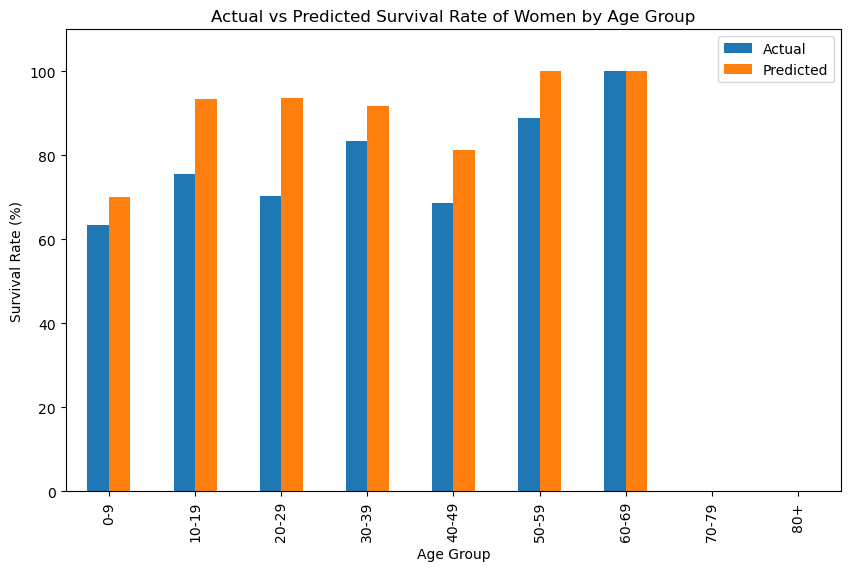

In [49]:
# Suppose y_pred is your model's predictions for train set
train['y_pred'] = model.predict(X)  # Or use y_pred_train if already available
train['Sex_label'] = train['Sex'].map({0: 'male', 1: 'female'})

# Age bins
train['AgeGroup'] = pd.cut(
    train['Age'],
    bins=list(range(0, 90, 10)) + [100],  # 0-9, 10-19, ..., 80-99
    right=False,
    labels=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
)

# Focus on women
df_women = train[train['Sex_label']=='female']

# Group and aggregate
actual = df_women.groupby('AgeGroup')['Survived'].mean()
predicted = df_women.groupby('AgeGroup')['y_pred'].mean()

df_compare = pd.DataFrame({'Actual': actual, 'Predicted': predicted}) * 100

df_compare.plot(kind='bar', figsize=(10,6))
plt.title("Actual vs Predicted Survival Rate of Women by Age Group")
plt.ylabel("Survival Rate (%)")
plt.xlabel("Age Group")
plt.ylim(0, 110)
plt.show()